In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

#download dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [2]:
# Check for TPU
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print('Running on TPU')
except ValueError:
    print('Not connected to a TPU runtime. Using CPU/GPU strategy.')
    strategy = tf.distribute.get_strategy()


Not connected to a TPU runtime. Using CPU/GPU strategy.


In [3]:
#normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
x_train=np.dot(x_train[...,:3], [0.299, 0.587, 0.114])
x_test=np.dot(x_test[...,:3], [0.299, 0.587, 0.114])
#add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
#split the dataset into train and valid
s = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=1/6)
train_index, valid_index = next(s.split(x_train, y_train))
x_valid, y_valid = x_train[valid_index], y_train[valid_index]
x_train, y_train = x_train[train_index], y_train[train_index]
print(x_train.shape, x_valid.shape, x_test.shape)

(41666, 32, 32, 1) (8334, 32, 32, 1) (10000, 32, 32, 1)


In [6]:
#create and compile the model within the TPU strategy scope
with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='elu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=['sparse_categorical_accuracy']
    )

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 32, 32, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,078,222 (7.93 MB)

 Trainable params: 2,077,836 (7.93 MB)

 Non-trainable params: 386 (1.51 KB)

In [11]:
%%time
#data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

#fit the data generator
datagen.fit(x_train)

batch_size = 128

#data generator
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

#calculate steps per epoch as an integer
steps_per_epoch = int(np.ceil(len(x_train) / batch_size))

#Early Stopping callback to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

#fit the model with validation data
history = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stop]
)

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - loss: 0.8739 - sparse_categorical_accuracy: 0.7069 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.7676
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.7676
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 0.8190 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.7640
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.7640
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 0.8187 - sparse_categorical_accuracy: 0.7248 - val_loss: 0.7034 - val_sparse_categorical_accuracy: 0.7696
CPU times: user 1min 22s, sys: 1.57 s, total: 1min 24s
Wall time: 1min 8s


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


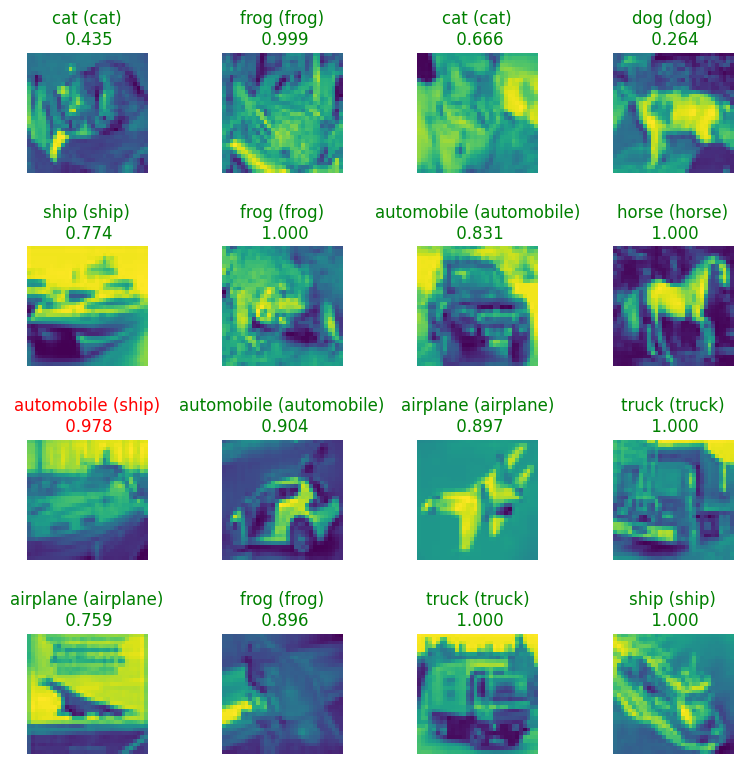

In [14]:
LABEL_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cpu_model = model

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, true_labels):
    n = images.shape[0]
    nc = int(np.ceil(n / 4))
    f, axes = pyplot.subplots(nc, 4)
    f.tight_layout()

    for i in range(nc * 4):
        if i >= n:
            break
        y = i // 4
        x = i % 4
        axes[x, y].axis('off')

        label = LABEL_NAMES[np.argmax(predictions[i])]
        confidence = np.max(predictions[i])

        axes[x, y].imshow(images[i])
        pred_label = np.argmax(predictions[i])
        axes[x, y].set_title("{} ({})\n {:.3f}".format(
            LABEL_NAMES[pred_label],
            LABEL_NAMES[true_labels[i][0]],
            confidence
        ), color=("green" if true_labels[i][0] == pred_label else "red"))

    pyplot.gcf().set_size_inches(8, 8)

plot_predictions(
    np.squeeze(x_test[:16]),
    model.predict(x_test[:16]),
    y_test[:16]
)

In [15]:
%%time
#evaluate the model on valid set
score = cpu_model.evaluate(x_valid, y_valid, verbose=0)

print('\n', 'Valid accuracy:', score[1])


 Valid accuracy: 0.7696184515953064
CPU times: user 1.04 s, sys: 92.8 ms, total: 1.13 s
Wall time: 1.41 s


In [16]:
%%time
#evaluate the model on test set
score = cpu_model.evaluate(x_test, y_test, verbose=0)

print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.770799994468689
CPU times: user 1.55 s, sys: 120 ms, total: 1.67 s
Wall time: 2.71 s
